# Popularity Prediction of User-Posts 
# on the website of Austrian Newspaper 'Der Standard'

This noteboook deal with the challenge of prediction the popularity (measured by up- and downvotes) of user-posts in the comments-section under articles of the Austrian Newspaper 'Der Standard'.

## Step 0 Set Up

### Step 0.1 Load Libraries

As a first step we load in the necessary libraries that we will use to accomplish this task.

In [5]:
# Text processing
import re

# Data manipulation
import pandas as pd
import numpy as np
import sqlite3

# Graphics and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.cm as cm

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR

# for tracking time
from tqdm import tqdm

### Step 0.2 Load Data

In [2]:
# Relative path to the SQLite database file
database_file = "./data/corpus.sqlite3"

# Connect to the database
conn = sqlite3.connect(database_file)

# Query to fetch the first 100,000 rows from a table named 'your_table_name'
query = "SELECT * FROM Posts"

# Load data into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()


## Step 1: Explorative Data Analysis 

In order to develop a feeling for the data, step 1 focuses on analyzing and visualizing the dataset.

### Step 1.1. Boxplot of Positive & Negative Votes

In order to get a feeling for how the values of Up- and Downvotes are distributed, we generate two boxplots, one for the upvotes feature, and one for the downvotes feature.

In [3]:
def make_box_plot(column, df):
    """
    Function to create a boxplot for a column in the dataframe
    Inputs:
    Name of the Column to make boxplot for (string)
    A Pandas data frame object 
    """

    # Set style
    sns.set_style("whitegrid")

    # Adjust the figure size
    plt.figure(figsize=(8, 2))

    # Create the box plot
    ax = sns.boxplot(x=df[column], orient='h', fliersize=1, color='lightblue')

    # Set title
    ax.set_title("Distribution of " + column +  " (Log Scale)", fontsize=16)

    # Set x-axis label
    ax.set_xlabel("Number of "+ column, fontsize=14)

    # Remove y-axis label
    ax.set_ylabel("")

    # Set logarithmic scale for x-axis
    ax.set_xscale('log')

    # Set ticks on the x-axis
    custom_ticks = [1, 2, 3, 4, 5, 6, 8, 10, 20, 30, 50, 100, 500]
    plt.xticks(custom_ticks, [str(i) for i in custom_ticks], fontsize=16)

    # Remove top and right spines
    sns.despine()
    
    # Save the plot
    plt.savefig('./figures/boxplot_' + column + '.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.tight_layout()
    plt.show()

    


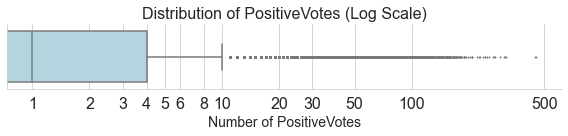

In [4]:
make_box_plot('PositiveVotes', df)

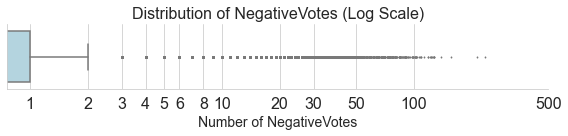

In [5]:
make_box_plot('NegativeVotes', df)

### Step 2.2. Heatmap of Positive and Negtive Votes

In order to analyzse the distribution further, a heatmap is generated.

In [27]:
# Define custom intervals for PositiveVotes and NegativeVotes
positive_intervals = [(0, 0), (1, 1), (2, 3), (4, 9), (10, 19), (20, 49), (50, 99), (100, 500)]
negative_intervals = [(0, 0), (1, 1), (2, 3), (4, 9), (10, 19), (20, 49), (50, 99), (100, 500)]

# Create result DataFrame with named columns and rows
result_df = pd.DataFrame(0, index=[f'{interval[0]}-{interval[1]}' for interval in negative_intervals],
                         columns=[f'{interval[0]}-{interval[1]}' for interval in positive_intervals])

# Iterate through each post and update the count in the result DataFrame
for _, row in df.iterrows():
    neg_interval = None
    pos_interval = None

    
    # Find the index of the negative interval
    for i, interval in enumerate(negative_intervals):
        if interval[0] <= row['NegativeVotes'] <= interval[1]:
            neg_interval = i
            break
            
    # Find the index of the positive interval
    for i, interval in enumerate(positive_intervals):
        if interval[0] <= row['PositiveVotes'] <= interval[1]:
            pos_interval = i
            break
    
    if neg_interval is not None and pos_interval is not None:
        result_df.iloc[neg_interval, pos_interval] += 1
        # row = interval for downvoates - column = interval for upvotes


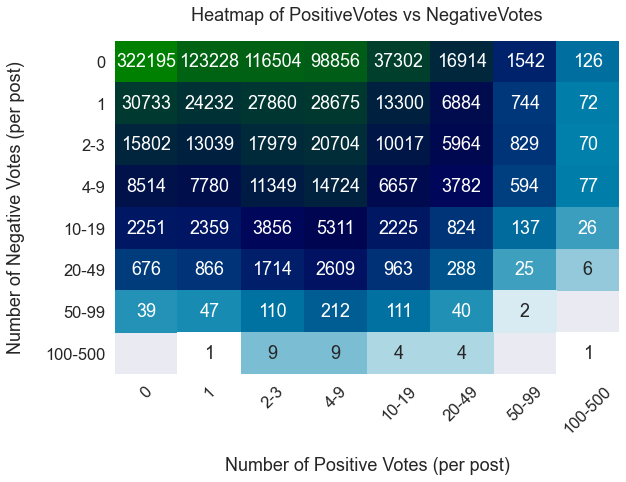

In [21]:

# Rename columns and index
result_df.rename(columns={'1-1': '1', '0-0': '0'}, 
                 index={'1-1': '1', '0-0': '0'}, 
                 inplace=True)

# Get the colormap 
cmap = cm.get_cmap('ocean')
# Flip the colormap
flipped_cmap = cmap.reversed()

# Set font scale for the heatmap and axis labels
sns.set(font_scale=1.5)  # Adjust font scale as needed

# Plot heatmap for PositiveVotes with logarithmic color scale
plt.figure(figsize=(10, 8))
sns.heatmap(result_df, cmap=flipped_cmap, annot=True, fmt='d', cbar=False, 
            norm=LogNorm(vmin=1, vmax=result_df.max().max()))
plt.title('Heatmap of PositiveVotes vs NegativeVotes', pad=20)  # Adjust title padding
plt.xlabel('Number of Positive Votes (per post)', labelpad=20)  # Adjust x label padding
plt.ylabel('Number of Negative Votes (per post)', labelpad=20)  # Adjust y label padding
plt.xticks(rotation=45)  # Rotate x ticks for better visibility
plt.yticks(rotation=0)   # Rotate y ticks for better visibility
plt.tight_layout(pad=3.0)  # Adjust padding between plot and figure edges


plt.savefig("./figures/heatmap.png", dpi=300, bbox_inches='tight' )
plt.show()


### Step 2.3. Overview of all posts

Next we generate an overview about how many posts have at least one vote (positive or negative), at least one positive or at least one negative votes.

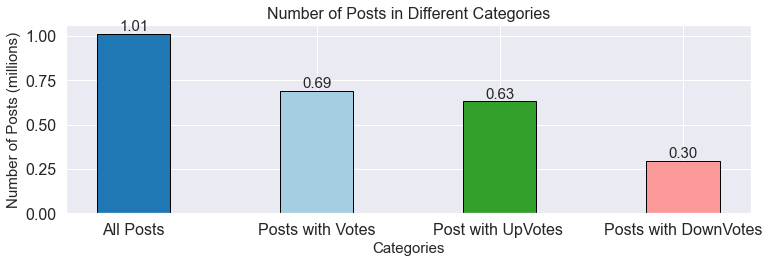

In [9]:
all_posts = df["ID_Post"].count()
all_posts_with_votes = df[(df["PositiveVotes"] > 0) | (df["NegativeVotes"] > 0)]["ID_Post"].count()
positive_posts = df[(df["PositiveVotes"] > 0)]["ID_Post"].count()
negative_posts = df[(df["NegativeVotes"] > 0)]["ID_Post"].count()

# Convert values to millions
all_posts /= 1e6
all_posts_with_votes /= 1e6
positive_posts /= 1e6
negative_posts /= 1e6

# Define categories and their corresponding values
categories = ['All Posts', 'Posts with Votes', 'Post with UpVotes ', 'Posts with DownVotes']
values = [all_posts, all_posts_with_votes, positive_posts, negative_posts]

# Choose a more suitable color palette
colors = ['#1F78B4', '#A6CEE3',   '#33A02C', '#FB9A99']
# Create bar plot
plt.figure(figsize=(11, 4))
bars = plt.bar(categories, values, color=colors, 
               edgecolor='black', width=0.4)  

# Add labels and title
plt.xlabel('Categories', fontsize=15)
plt.ylabel('Number of Posts (millions)', fontsize=15)
plt.title('Number of Posts in Different Categories', fontsize=16)

# Increase font size for tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Show the value on top of each bar with larger font size
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=15)

# Save the plot
plt.savefig('./figures/bar_plot.png', dpi=300, bbox_inches='tight')
# Show plot
plt.tight_layout()
plt.show()



In [10]:
print(f"The median number of Upvotes is: { df.PositiveVotes.median() }")
print(f"The median number of Downvotes is: { df.NegativeVotes.median() }")


print(f"The mean number of Upvotes is: { df.PositiveVotes.mean() }")
print(f"The mean number of Downvotes is: { df.NegativeVotes.mean() }")

The median number of Upvotes is: 1.0
The median number of Downvotes is: 0.0
The mean number of Upvotes is: 3.7803005219550236
The mean number of Downvotes is: 1.0835434430450308


### Step 2.4. Looking at the Data

Next we look at a few example for posts with more than 10 upvotes or posts with more than 10 downvotes.

In [28]:
df[df["PositiveVotes"]>10].head(10)[["Headline", "Body"]].style

,Headline,Body
108,,Ist es schon überarbeitet? Ich möchte wieder so berühmt werden wie früher. Das hat mir damals sagenhaft viele perverse Kontakte verschafft.
109,"""Multiuser"" und ""Bewertungsuser""?","Gibt es eine Meldeadresse/-stelle an die man sich wenden kann, wenn man annimmt einen ""Multiuser"" (mehrfach registrierten Benutzer) gefunden zu haben? Und was ist mit Usern die schon länger registriert sind, selbst 0 Postings verfasst haben und in Threads auffallend oft von oben bis unten durchgehend nur mit rot oder grün bewerten?"
157,Zugriff zu den eigenen ...,...posts bzw. Konto wäre eine gute Erweiterung....
189,"Oh, wie schön, heute ist m e i n Tag! :-)","Beste Grüße an alle Mit-Lefties dieser Erde und auch Nicht-Erde!!! Erfahrungen: # wirkliche Probleme, sehr eindrücklich als Kind zB beim Werken/Basteln, haben mir immer bestimmte Scheren gemacht (die z.B. dann total in der Hand weh tun, wenn links gehalten, oder einfach eher reißen als schneiden) # das eindrücklichste Erlebnis ist ein paar Jahre her: in einer Café-Lokation auf der Wiener Währinger Straße wurde mir meine Melange in einer Tasse serviert, deren ""ergonomisch"" schiefer/geschwungener Griff für eine rechte Hand (wohl) sehr gut passt - mit der linken Hand kann man das Häferl dadurch aber praktisch kaum halten... # beim Sporteln war mein Lefty-tum, glaub ich, immer nur ein Vorteil :-) ;-)"
206,,"wenn mir jemand bezüglich meiner handwerklichen Fähigkeiten gesagt hat, dass ich zwei Linke habe, habe ich mich für das Komplement bedankt."
215,,"am allerschlimmsten sind saucenschöpfer mit schnabel... da kann ich machen was ich will, ich kann diese teile einfach nicht bedienen.. die sauce rinnt überall hin, nur nicht auf den teller..."
289,,"Die Meinl-Häferln sind wirklich eine sinnlose Geschichte. Glückwunsch an den Designer für Hirnlosigkeit im Dienst - auch wenn es Linkshänder-Exemplare theoretisch geben tät, kein Restaurant würde die bestellen. Scheren sind ein kleines Problem, wobei ich mir mit einer Linkshänderschere auch weh tu - weil schon zu lange an die falschen Scheren gewohnt. Wenn man sich aber ausschließlich mit Linkshänderprodukten umgibt, ""sperrt"" man sih quasi von der dominierenden Rechtshänderwelt ab. Letztendlich drängt einem das Linkshändertum ein wenig, den Individualisten zu spielen - mir hat's nicht geschadet, oder ich merk's nicht."
297,,"Meine Großmutter hat mir mal erzählt, dass sie in der Schule noch geohrfeigt wurde, weil sie Linkshänderin war. Umlernen wurde gefordert, nicht nur in der Schule, sondern auch vom Elternhaus (natürlich auch mit Prügel verbunden) - kann mir nicht vorstellen, was für Leid das in einem Kind/Jugendlichen verursacht, wegen so einer Lappalie unter Druck gesetzt und verdroschen zu werden. Heute kann sie beide Hände fast gleich nutzen, präferiert bei den meisten Sachen jedoch die Linke."
347,,"Als Linkshänder, welcher die Computer Maus mit der rechten bedient, kann ich gleichzeitig etwas (ab)schreiben und mit der Maus am Computer zB Textstellen markieren und scrollen ;)"
386,UMFRAGE FÜR LINKSHÄNDER:,Benutzt ihr am PC/iThing die Maus/das Touchpad mit der linken oder rechten Hand? Links: grün Rechts: rot


In [29]:
df[df["NegativeVotes"]>10].head(10)[["Headline", "Body"]].style

,Headline,Body
235,,Zum Sport: Wer schießt (wie ich) beim Fußball mit rechts? Wer ist links unterwegs? rot=links grün=rechts
386,UMFRAGE FÜR LINKSHÄNDER:,Benutzt ihr am PC/iThing die Maus/das Touchpad mit der linken oder rechten Hand? Links: grün Rechts: rot
759,,"schön. Bis zu jenem Tag, als die Trabis die Mariahilferstraße verstopft haben mit den Waschmaschinen am Dachl."
884,,"Ich hab jene Ostdeutschen bedauert, die den Versprechungen von Kohl und Genscher geglaubt haben."
1085,,"Wenn das so schlimm war, wieso hast sie dann überhaupt wiedergesehen? Oder wars nur für eine Nacht?"
1113,,das is ja wirklich grauslich - ich hätt' Euch auch nicht rein gelassen
1120,,In London gibts außergewöhnlich gute Hotels. Man muss sie sich halt leisten können und wollen. ;-)
1123,,DAnn frage ich dich nochmal: Was war damals an dem Erlebnis so schlimm?
1129,,"Im Nachhinein ist was anderes, ich glaube, hier gehts darum, welches Hotelerlebnis man im Moment des Erlebens als schlimm empfand. Also eher off topic, hier von kaputten späteren Beziehungen zu plaudern. :-)"
1251,,"dann graust mir davor, wie Dich Deine Ex-Frau umgedreht hat *brr*"


Most interestingly we see here for example that users misuse the functionality the downvotes and upvotes to start a survey (as shown in the first two rows).

## Step 2: Feature Generation

Next we generate the features to train our models with.

In [3]:

# Calculate text body length
df['BodyWordLength'] = df['Body'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
# Calculate headline length
df['HeadlineWordLength'] = df['Headline'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
# Calculate text body length
df['BodyLength'] = df['Body'].apply(lambda x: len(x) if isinstance(x, str) else 0)  
# Calculate headline length
df['HeadlineLength'] = df['Headline'].apply(lambda x: len(x) if isinstance(x, str) else 0)


def has_conjunctive(text):
    """a function to check for conjunctive words in German
    """
    if pd.isnull(text):
        return 0
    conjunctive_words = ['wäre', 'könnte', 'müsste', 'sollte']  # Add more if necessary
    pattern = r'\b(?:' + '|'.join(conjunctive_words) + r')\b'
    return 1 if re.search(pattern, text) else 0


def has_question(text):
    """a function to check for questions in the post
    """
    if pd.isnull(text):
        return 0
    return 1 if '?' in text else 0


def has_spelling_mistakes(text):
    """a function to check for common spelling and syntax mistakes in German
    """
    if pd.isnull(text) or len(text) == 0:
        return 0
    # Check for capitalization errors after a dot
    if re.search(r'\.\s*[a-zäöüß]', text):
        return 1
    #search for other mistakes
    if re.search(r'und[a-zäöüß]', text):
        return 1
    if re.search(r'oder[a-zäöüß]', text):
        return 1
    # Check if the first letter of a sentence is not capitalized
    #if not text[0].isupper():
     #   return 1
    # Add more checks
    return 0


def has_graditude(text):
    """a function to check for common spelling and syntax mistakes in German
    """
    if pd.isnull(text) or len(text) == 0:
        return 0
    #search for some graitude
    if re.search(r'danke', text, re.IGNORECASE):
        return 1
    if re.search(r'bitte', text, re.IGNORECASE):
        return 1
    if re.search(r'lieb', text, re.IGNORECASE):
        return 1
    return 0

def extract_features(df):
    """A function to Integrate the new features into the baseline model
    """
    df['Conjunctive'] = df['Body'].apply(has_conjunctive)
    df['Question'] = df['Body'].apply(has_question)
    df['SpellingMistakes'] = df['Body'].apply(has_spelling_mistakes)
    df['Graditude'] = df['Body'].apply(has_graditude)
    return df

df = extract_features(df)
X_baseline2 = df[['PositiveVotes', 'BodyWordLength', 'HeadlineWordLength', 'BodyLength', 'HeadlineLength', 'Conjunctive', 'Question', 'SpellingMistakes']]


## Step 3: Define Models

Next we define a function to train our models and we dfine our baselines

In [34]:


# Define the training function with SGDRegressor
def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    return model

# Define baseline models
baseline_models = {
    'Baseline 1': df[['PositiveVotes']].mean(),
    'Baseline 2': df[['BodyWordLength', 'HeadlineWordLength', 'BodyLength', 'HeadlineLength']],
    'Baseline 3': df[['BodyWordLength', 'HeadlineWordLength', 'BodyLength', 'HeadlineLength',
                      'SpellingMistakes', 'Conjunctive', 'Question', 'Graditude']]
}

## Step 4: Train & Evaluate Models

Finally we evaluate the models

In [35]:
def evaluate_baseline_1(median_value, y_train, y_test):
    y_pred_train = np.full_like(y_train, median_value)
    y_pred_test = np.full_like(y_test, median_value)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    return mse_train, mse_test, mae_train, mae_test

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    return mse_train, mse_test, mae_train, mae_test

def create_evaluation_df(model_name, mse_train, mse_test, mae_train, mae_test):
    return pd.DataFrame([
        {'Model': model_name, 'Evaluation': 'Train', 'MSE': mse_train, 'MAE': mae_train},
        {'Model': model_name, 'Evaluation': 'Test', 'MSE': mse_test, 'MAE': mae_test}
    ])

# Evaluate each baseline model
evaluation_dfs = []
for model_name, X_baseline in baseline_models.items():
    if model_name == 'Baseline 1':
        # Special handling for Baseline 1
        y_train, y_test = train_test_split(df['PositiveVotes'], test_size=0.2, random_state=42)
        median_value = X_baseline 
        mse_train, mse_test, mae_train, mae_test = evaluate_baseline_1(median_value, y_train, y_test)
        evaluation_df = create_evaluation_df(model_name, mse_train, mse_test, mae_train, mae_test)
    else:
        # General case for other baselines
        X_train, X_test, y_train, y_test = train_test_split(X_baseline, df['PositiveVotes'], test_size=0.2, random_state=42)
        model = train_model(X_train, y_train)
        mse_train, mse_test, mae_train, mae_test = evaluate_model(model, X_train, y_train, X_test, y_test)
        evaluation_df = create_evaluation_df(model_name, mse_train, mse_test, mae_train, mae_test)

    evaluation_dfs.append(evaluation_df)

evaluation_df = pd.concat(evaluation_dfs, ignore_index=True)
print(evaluation_df)

        Model Evaluation        MSE       MAE
0  Baseline 1      Train  60.043533  3.924837
1  Baseline 1       Test  59.552010  3.932184
2  Baseline 2      Train  39.061704  3.356507
3  Baseline 2       Test  63.876698  4.475414
4  Baseline 3      Train  33.226623  3.091509
5  Baseline 3       Test  65.196244  4.553605


As we can see from the evaluation dataframe the Random Forest models currently overfit, an efford to tackle this issue will be part of the further development of this code.